# GMM Brain Segmentation with Bias Field Correction

This jupyter notebook will guide you on how to segment a 3D MRI image in different classes () using a Gaussian Mixture Model (GMM) with a bias field corrction model.

One of the limitations of GMM Brain Segmentation is that it doesn’t take into account image artifacts present in the scan. This is quite problematic since most of the MRI scans suffer from an image artifact called bias field.

Ref:https://www.stefanocerri.com/modeling-the-bias-field-in-brain-segmentation/.

In [28]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl    
import matplotlib.ticker as ticker
import numpy as np
import math
from scipy.stats import norm
# for display
sub_size = 16
sup_size=20

Load the input Image

In [2]:
dataFile = '../Data/brain.nii.gz'
maskFile = '../Data/brain_mask.nii'# Mask file, if any
brainImage = nib.load(dataFile).get_fdata()
maskImage = nib.load(maskFile).get_fdata()

Visualize the data in axial, coronal and sagittal view.
Feel free to change the value of the array slices to see the different slices in axial, coronal and sagittal view.

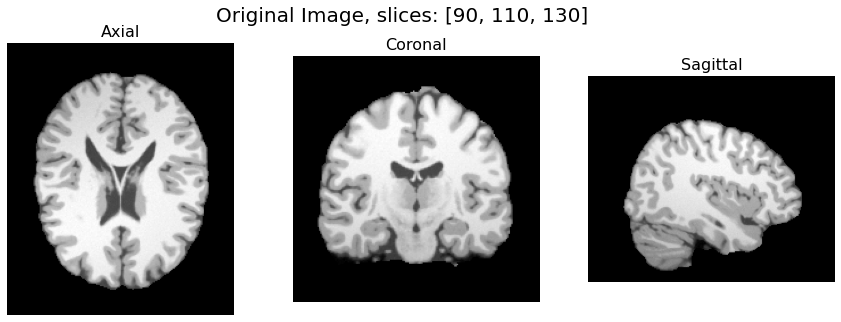

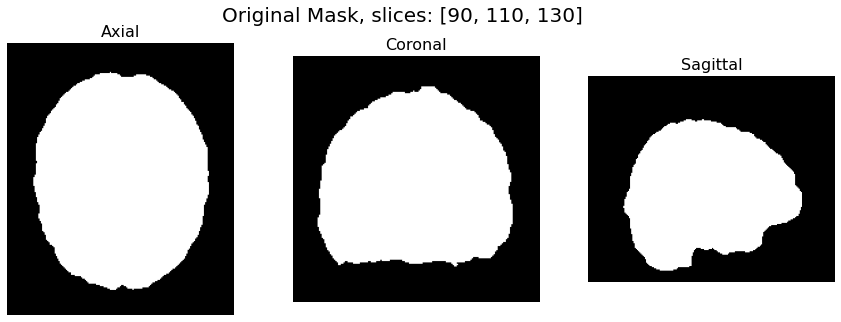

In [7]:
def plotOriginalImage(image, slices, title):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5),)
    fig.suptitle(title+', slices: ' + str(slices), fontsize=sup_size)
    ax1.imshow(image[slices[0], :, :], cmap='gray'); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
    ax2.imshow(image[::-1,slices[1],::-1], cmap='gray'); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
    ax3.imshow(image[::-1,:,slices[2]], cmap='gray'); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
    plt.show()

slices = [90, 110, 130]; bins = 100
plotOriginalImage(brainImage, slices, title='Original Image')
plotOriginalImage(maskImage, slices, title='Original Mask')

Let's plot the image histogram to see if we can see some intensities peaks that will be fitted by our Gaussian Mixture Model.

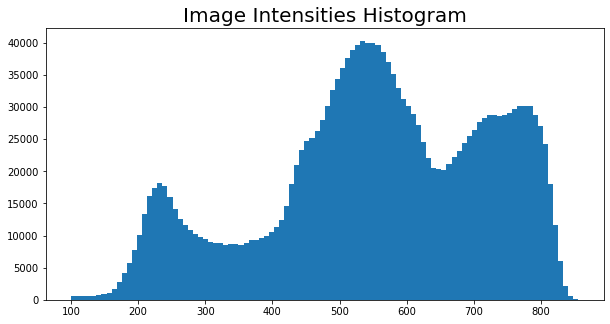

In [8]:
minIntensity = 100
mask = True
if mask:
    maskIndices = np.logical_and(np.array(maskImage, dtype=np.bool_), brainImage > minIntensity)
    brainIntensities = brainImage[maskIndices]
else:
    maskIndices = brainImage > minIntensity
    brainIntensities = brainImage[brainImage > minIntensity]

plt.figure(figsize=(10, 5))
_ = plt.hist(brainIntensities.ravel(), bins) 
plt.title("Image Intensities Histogram", fontsize=sup_size)
plt.show()

If we look at the histogram of the image above, we can see that it has three peaks, most probably representing CSF, GM, and WM.

Now let's create our GMM model. 
The fact that the histogram has three peaks is telling us that we can set the number of components of the GMM to 3. 
We are goint to initialize the GMM with means spread over the image intensity range and with wide variances
Feel free to change the number of components to see how the results change.

In [9]:
# Here you can define the number of components of the GMM
nComponents = 3

# Let's create the GMM parameters
GMM_means = np.zeros([nComponents, 1])
GMM_variances = np.zeros([nComponents, 1])
GMM_weights = np.zeros([nComponents])

# initialization: 
# -values of the means: every range/nClasses
# -values of the variances: 2*initialWidth
# -values of the weights: 1/nClasses
minIntensity = brainIntensities.min()
maxIntensity = brainIntensities.max()
initialWidth = (maxIntensity - minIntensity) / nComponents

for n in range(nComponents):
    GMM_means[n] = minIntensity + (n + 1) * (initialWidth)
    GMM_variances[n] = initialWidth**2
    GMM_weights[n] = 1/nComponents

Let's now create the bias field model. 
You can use more basis function as well as changing the basis function (e.g. instead of cos you can use sin).

In [25]:
# Bias field coefficients
showBasis=False
numberOfBasis=2
c = np.ones(numberOfBasis ** 3)

x = np.arange(0, brainImage.shape[0]) / brainImage.shape[0] * np.pi
y = np.arange(0, brainImage.shape[1]) / brainImage.shape[1] * np.pi
z = np.arange(0, brainImage.shape[2]) / brainImage.shape[2] * np.pi
basisX = np.zeros([numberOfBasis, brainImage.shape[0]])
basisY = np.zeros([numberOfBasis, brainImage.shape[1]])
basisZ = np.zeros([numberOfBasis, brainImage.shape[2]])

for base in range(numberOfBasis):
    basisX[base, :] = np.cos((base + 1) * x)
    basisY[base, :] = np.cos((base + 1) * y)
    basisZ[base, :] = np.cos((base + 1) * z)

basis = np.zeros([numberOfBasis ** 3, len(brainIntensities)])

b = 0
for i in range(numberOfBasis):
    for j in range(numberOfBasis):
        for k in range(numberOfBasis):
            tmp = np.expand_dims(np.expand_dims(basisX[i],1) 
                                 @ np.expand_dims(basisY[j], 0), 2) @ np.expand_dims(basisZ[k], 0)
            basis[b, :] = tmp[maskIndices]
            b = b + 1
            if showBasis:
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
                fig.suptitle('Base: ' + str(n+1), fontsize=sup_size)
                ax1.imshow(tmp[slices[0], :, :], cmap='gray'); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
                ax2.imshow(tmp[::-1,slices[1],::-1], cmap='gray'); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
                ax3.imshow(tmp[::-1,:,slices[2]], cmap='gray'); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
                plt.show()
            
def computeBiasField(c):
    return np.dot(c, basis)

Image intensities histogram where we superimpose our GMM with our initialization of the parameters.

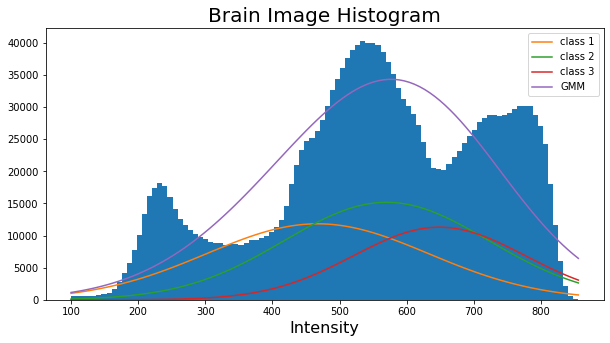

In [18]:
def plotHistWithGMM(bins, intensities=brainIntensities):
    plt.figure(figsize=(10, 5))
    minIntensity = intensities.min()
    maxIntensity = intensities.max()
    val, binsH, _ = plt.hist(intensities.ravel(), bins=bins) 
    area =  sum(np.diff(binsH)*val)
    plt.title("Brain Image Histogram", fontsize=sup_size)
    x = np.linspace(minIntensity, maxIntensity, bins)
    gmmNorm = np.zeros(x.shape)
    for n in range(nComponents):
        plt.plot(x, area * GMM_weights[n] * norm.pdf(x, GMM_means[n], np.sqrt(GMM_variances[n])), label='class ' + str(n + 1))
        gmmNorm +=  area * GMM_weights[n] * norm.pdf(x, GMM_means[n], np.sqrt(GMM_variances[n]))
    plt.plot(x, gmmNorm, label='GMM')
    plt.xlabel('Frequency', fontsize=sub_size)
    plt.xlabel('Intensity', fontsize=sub_size)
    plt.legend()
    plt.show()
    
plotHistWithGMM(bins, brainIntensities)

The figure above denotes that our GMM is far from fitting the data.
We can now start with the EM algorithm and see how well we can fit the data with our GMM model as well as plot our segmentation maps of our segmented brain structures.

Let's compute the initial segmentation (computing the posterior distribution and take the maximum argument) with this parameter initialization and show them. 
Here you can set up a flag if you want to see also the "soft" segmentation for each component.

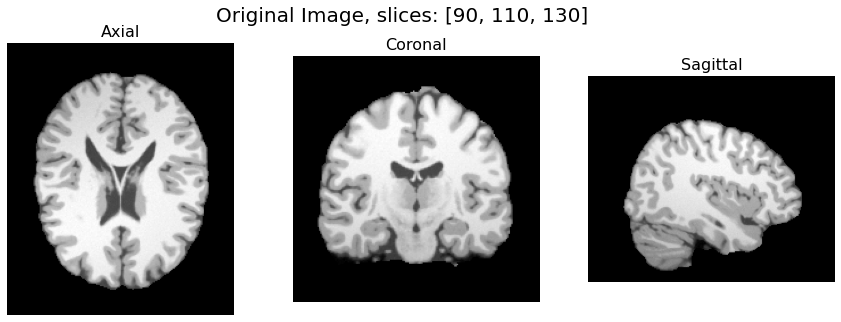

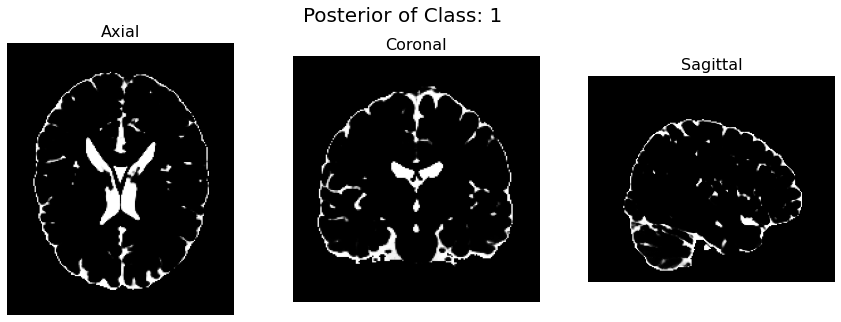

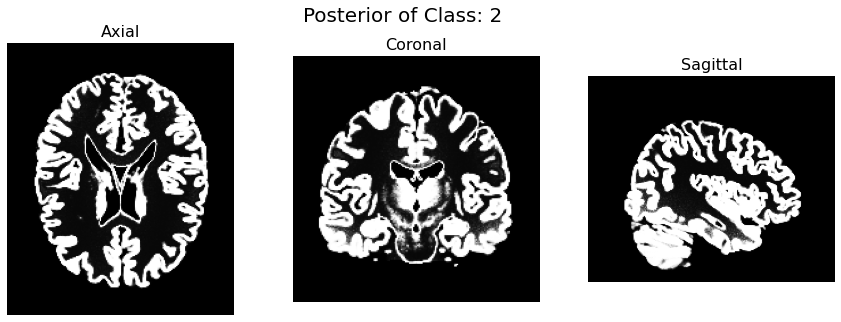

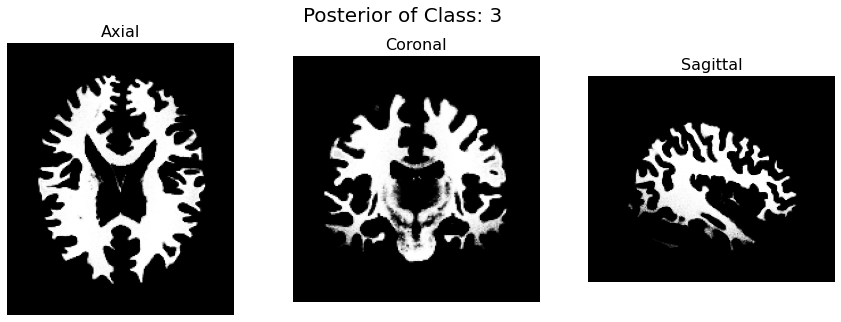

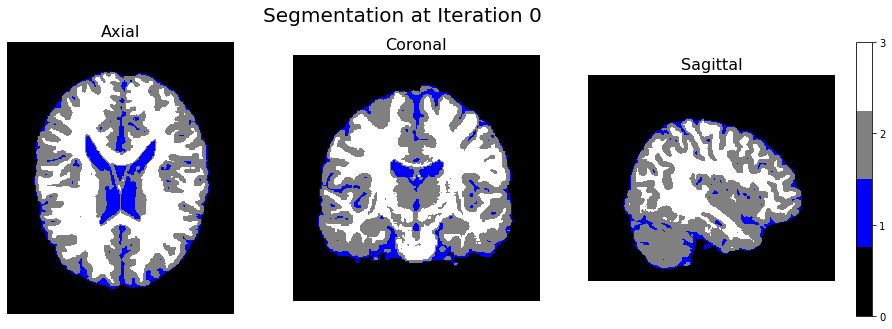

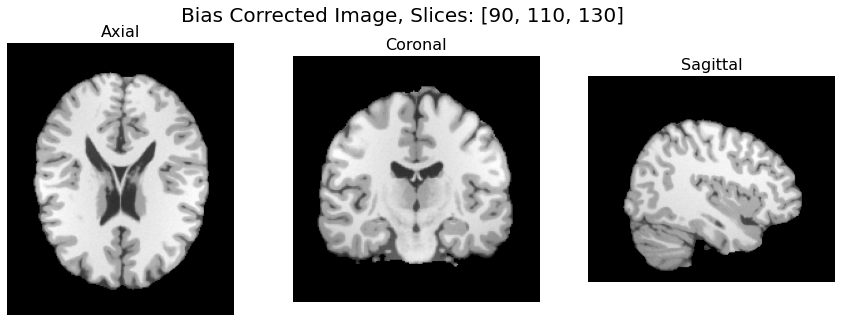

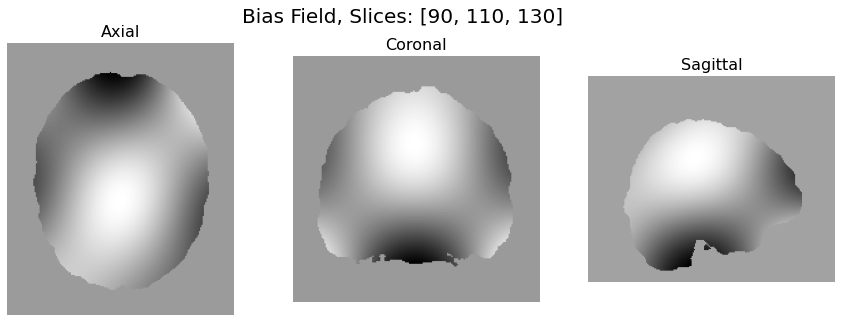

In [31]:
def plotSoftPosterior(slices):
    for n in range(nComponents):
        tmp = np.zeros(brainImage.shape)
        tmp[maskIndices] = posteriors[:, n]
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
        fig.suptitle('Posterior of Class: ' + str(n+1) , fontsize=sup_size)
        ax1.imshow(tmp[slices[0], :, :], cmap='gray'); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
        ax2.imshow(tmp[::-1,slices[1],::-1], cmap='gray'); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
        ax3.imshow(tmp[::-1,:,slices[2]], cmap='gray'); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
        plt.show()
        
def plotHardPosterior(slices, it=0):
    tmp = np.zeros(brainImage.shape)
    tmp[maskIndices] = hardSegmentation + 1
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    fig.suptitle('Segmentation at Iteration ' + str(it), fontsize=sup_size)
    cmp = mpl.colors.ListedColormap(['k', 'b', 'gray', 'w'])
    ax1.imshow(tmp[slices[0], :, :], cmap=cmp); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
    ax2.imshow(tmp[::-1,slices[1],::-1], cmap=cmp); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
    img3=ax3.imshow(tmp[::-1,:,slices[2]], cmap=cmp); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
         
    fig.subplots_adjust(right=0.9) # set width of the left three subplot equal to 0.9 
    # set the size of colorbar
    l=0.92; b=0.12; w=0.015; h=1-2*b #left, bottom, width, hight
    # set the position of colorbar
    rect = [l,b,w,h]
    cbar_ax = fig.add_axes(rect)
    cb1 = fig.colorbar(img3, cax=cbar_ax)
    # set the scale of colobar
    tick_locator = ticker.MaxNLocator(nbins=3)
    cb1.locator = tick_locator
    cb1.set_ticks([0,1,2,3])
    cb1.update_ticks()

    plt.show()

def plotBiasCorrectedImage(c, slices, it=0):
    tmp = np.zeros(brainImage.shape)
    tmp[maskIndices] = brainIntensities - computeBiasField(c)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5),)
    fig.suptitle('Bias Corrected Image, Slices: ' + str(slices), fontsize=sup_size)
    ax1.imshow(tmp[slices[0], :, :], cmap='gray'); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
    ax2.imshow(tmp[::-1,slices[1],::-1], cmap='gray'); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
    ax3.imshow(tmp[::-1,:,slices[2]], cmap='gray'); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
    plt.show()

def plotBiasField(c, slices, it=0):
    tmp = np.zeros(brainImage.shape)
    tmp[maskIndices] = computeBiasField(c)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5),)
    fig.suptitle('Bias Field, Slices: ' + str(slices), fontsize=sup_size)
    ax1.imshow(tmp[slices[0], :, :], cmap='gray'); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
    ax2.imshow(tmp[::-1,slices[1],::-1], cmap='gray'); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
    ax3.imshow(tmp[::-1,:,slices[2]], cmap='gray'); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
    plt.show()

# Flag for soft segmentation visual
softPlots = False

# Compute posteriors
correctedIntensities = brainIntensities - computeBiasField(c)
posteriors = np.zeros([len(brainIntensities), nComponents])
for n in range(nComponents):
    posteriors[:, n] = GMM_weights[n] * norm.pdf(correctedIntensities, GMM_means[n], np.sqrt(GMM_variances[n]))

# Normalize them
eps = np.finfo(float).eps
normalizer = np.sum(posteriors, axis=1)
posteriors = posteriors / (normalizer[:, np.newaxis] + eps)
hardSegmentation = np.argmax(posteriors, axis=1)

plotOriginalImage(brainImage, slices, title='Original Image')
plotSoftPosterior(slices)
plotHardPosterior(slices)
plotBiasCorrectedImage(c, slices)
plotBiasField(c, slices)

Since the introduction of the bias field model makes the updates of the GMM parameters slightly more complicated: i.e. the M-step of the EM algorithm has no closed-form solution.

To solve this problem we can use a generalized EM algorithm (GEM), where we can update the GMM parameters, while keeping the current bias field coefficient estimates fixed. We can then update these bias field coefficients while keeping the GMM parameters fixed.

Let's run the GEM algorithm for some iterations and see how the segmentation change. A more robust implementation would look at the log-likelihood (guaranteed to increase at each iteration) and set a minimum increase threshold.

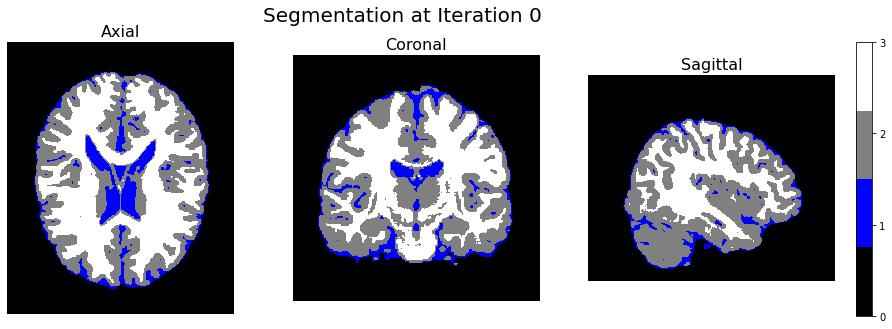

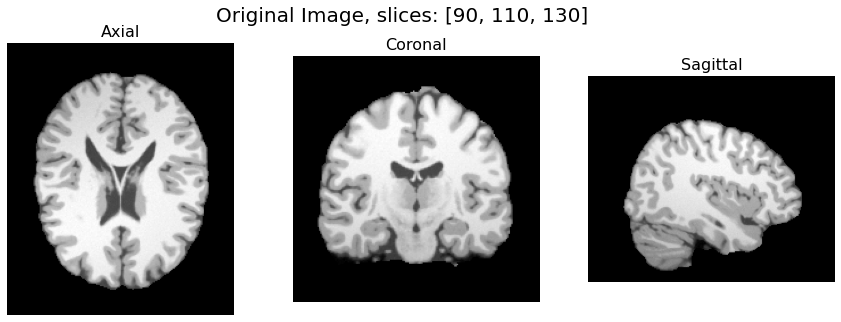

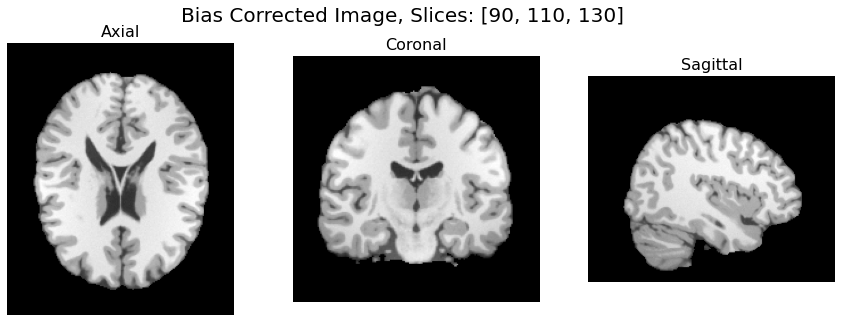

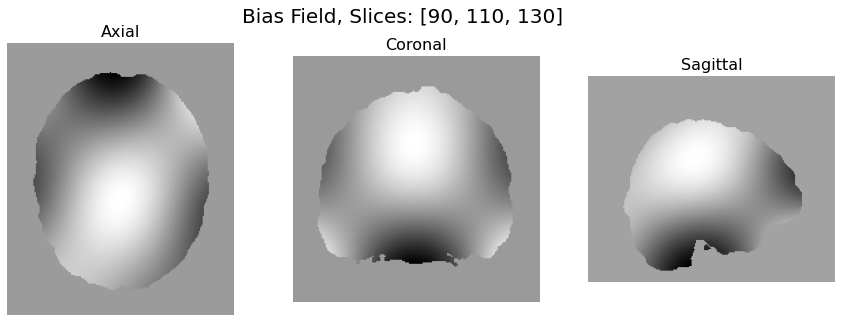

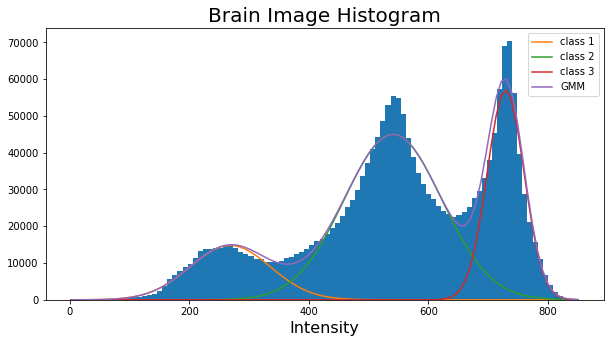

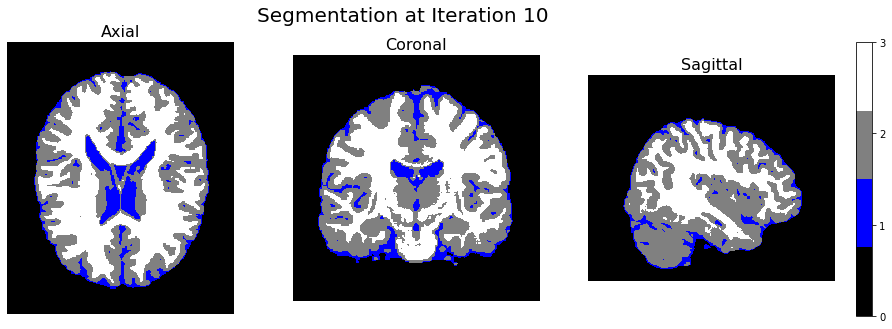

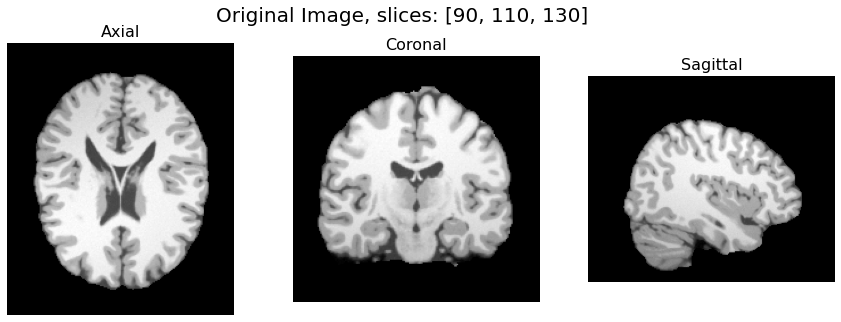

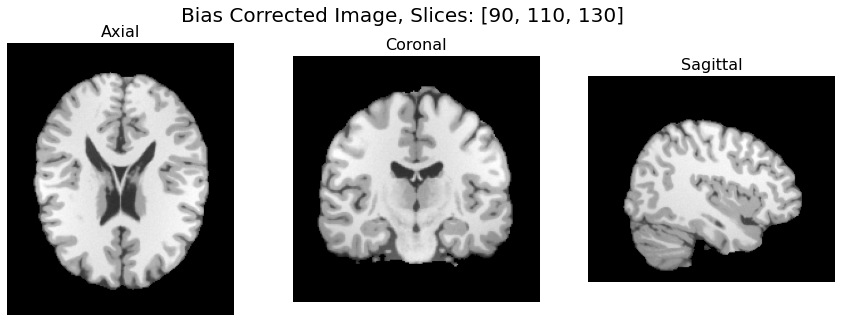

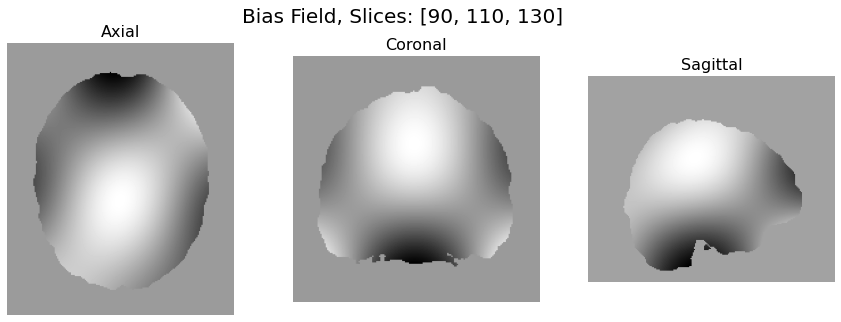

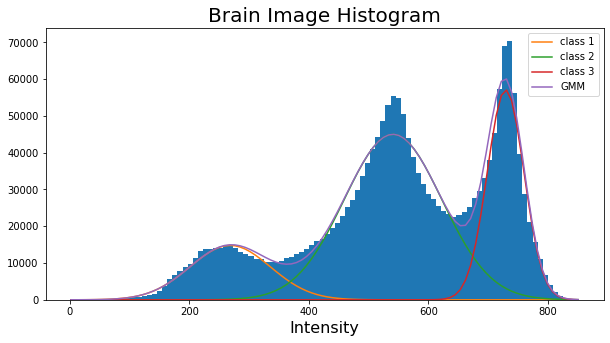

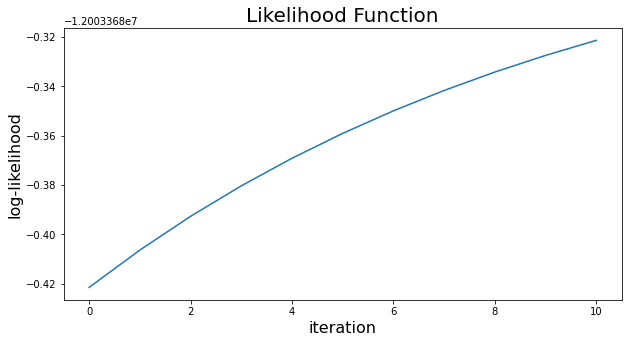

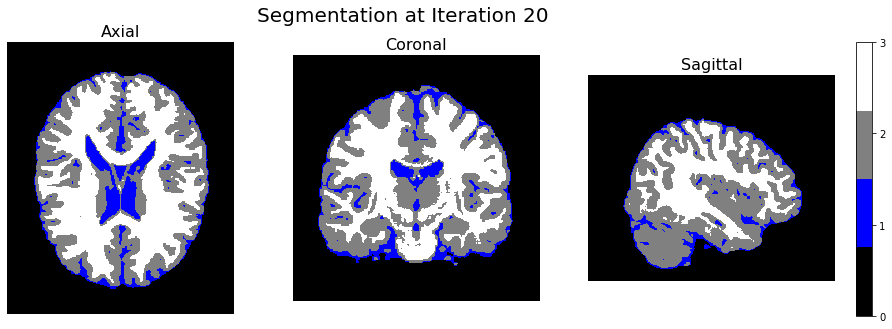

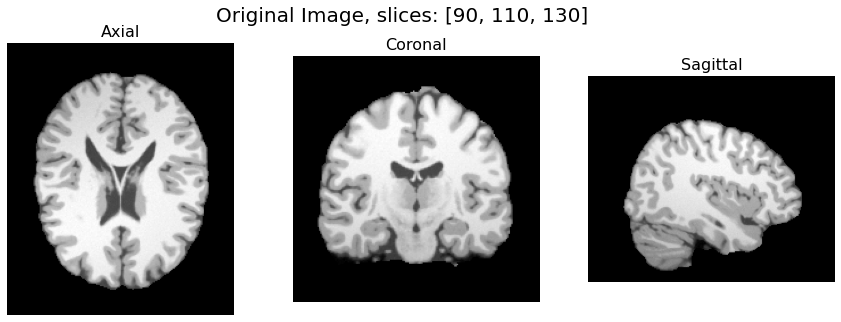

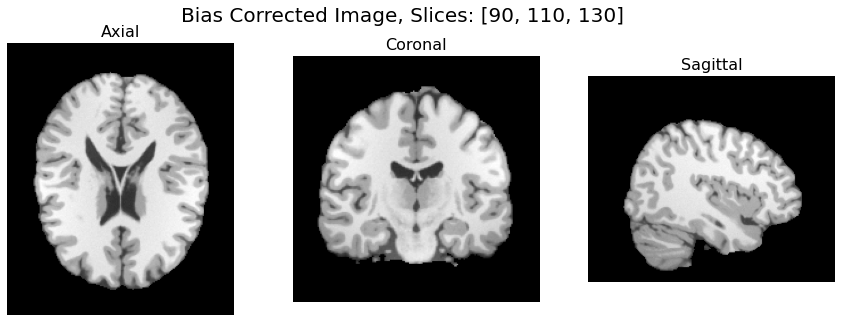

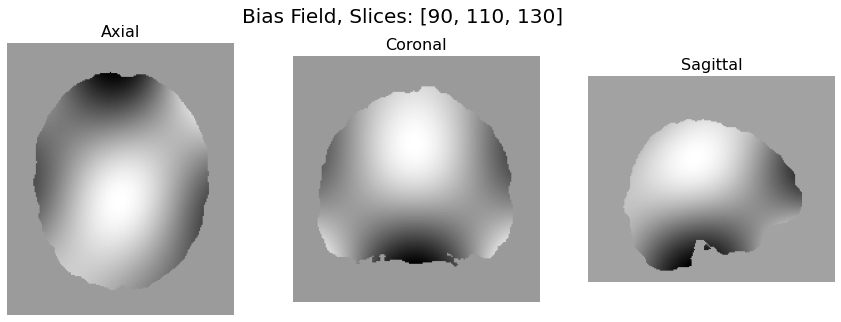

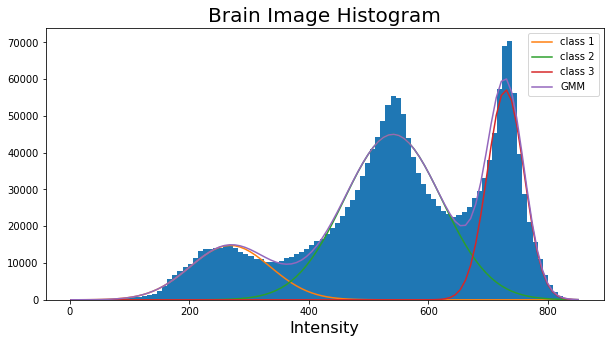

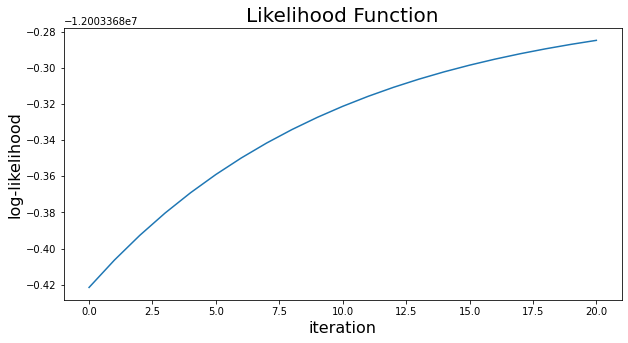

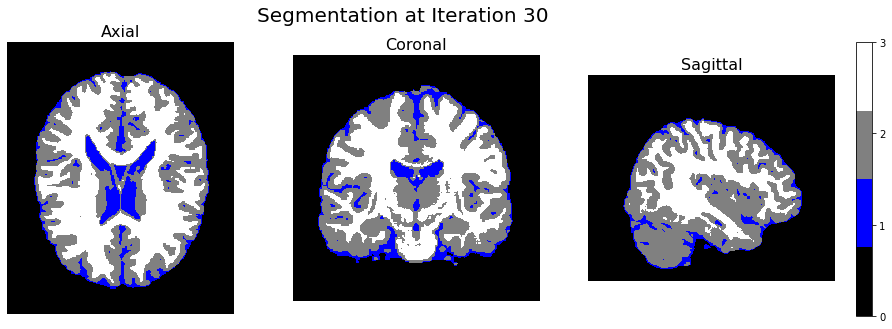

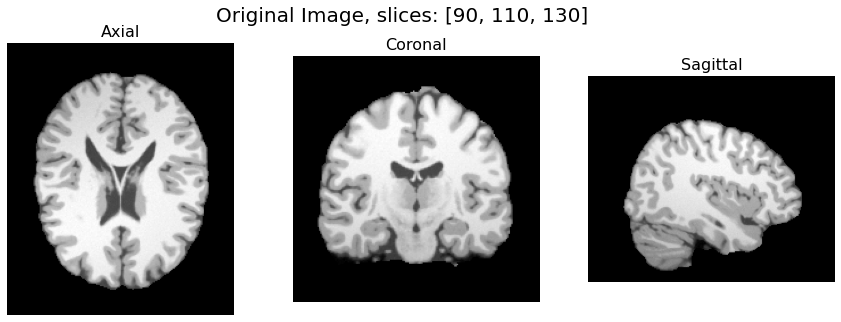

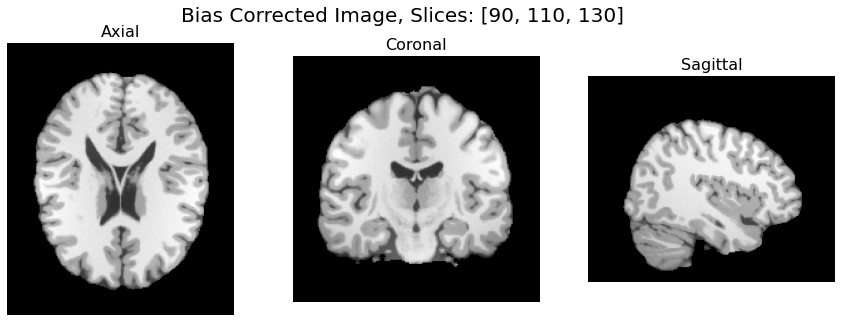

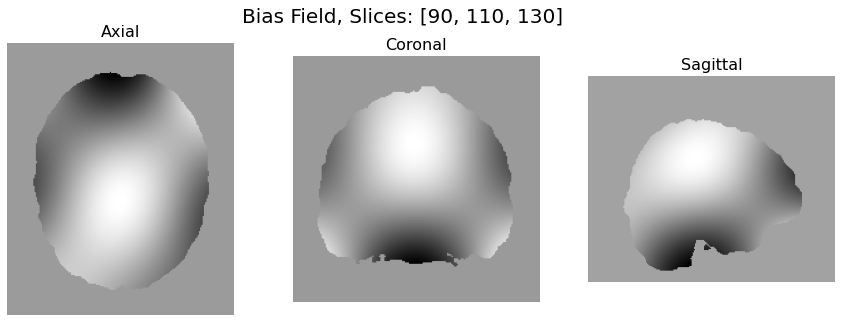

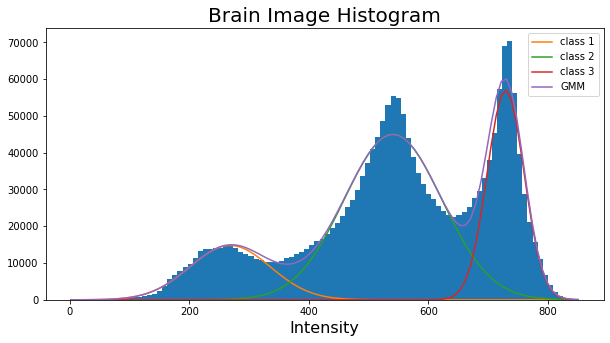

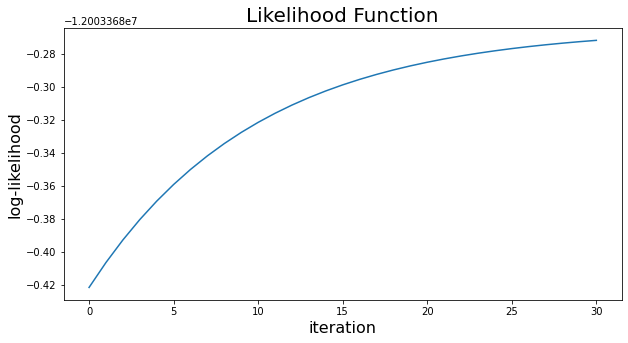

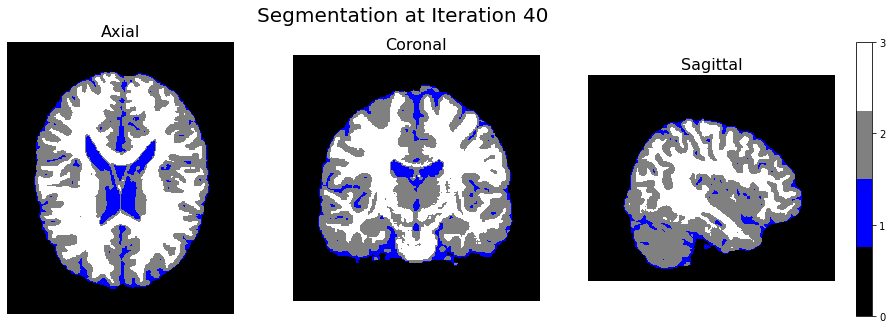

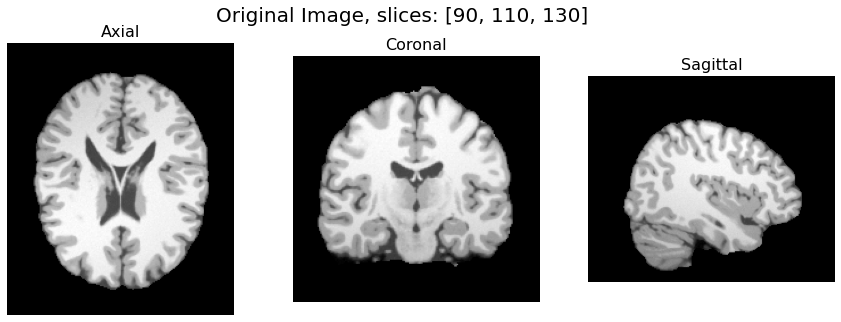

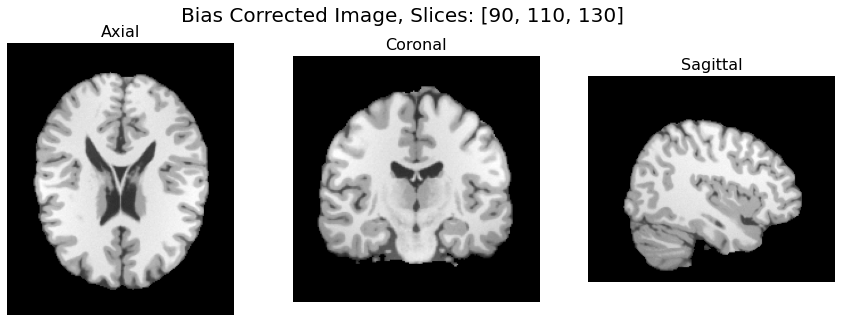

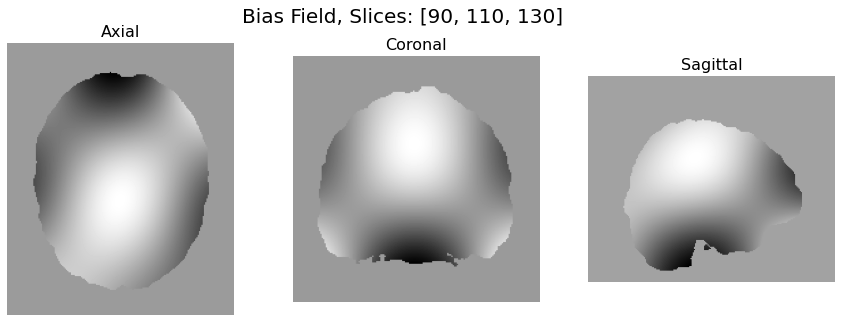

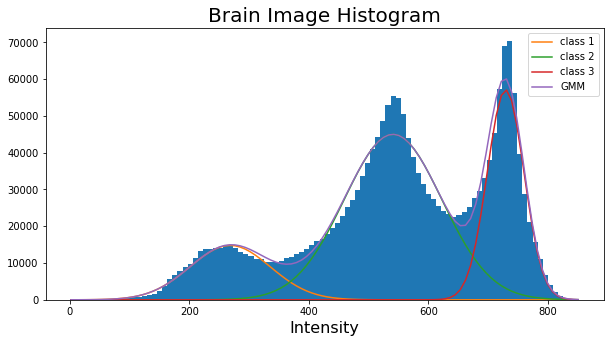

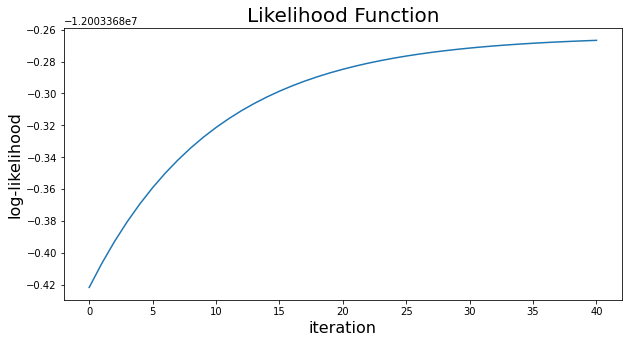

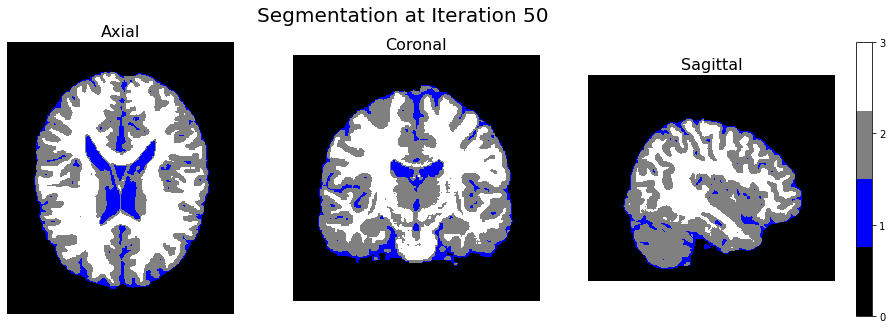

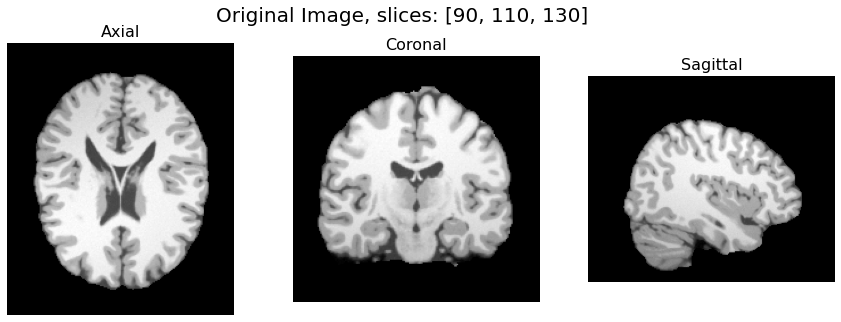

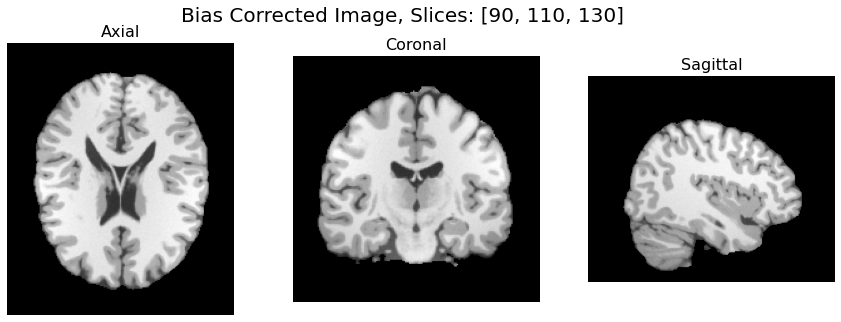

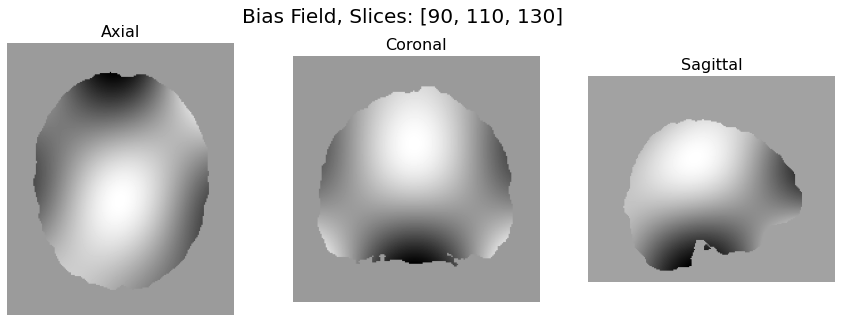

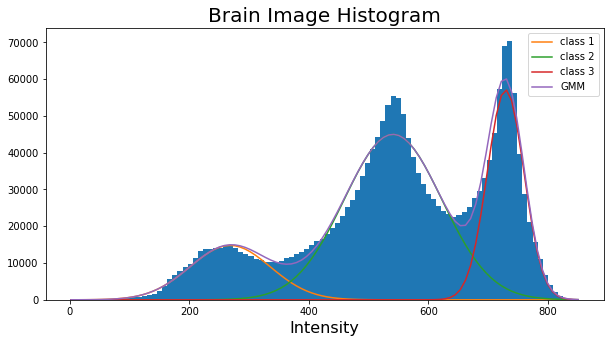

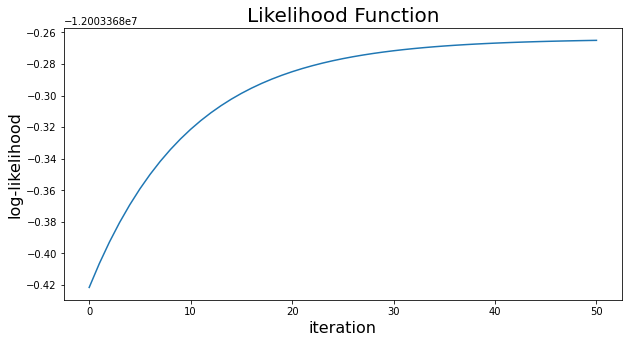

Algorithm converges since cost per iteration is smaller than minDifference


In [32]:
def plotLikelihood(likelihoodHistory):
    if len(likelihoodHistory) > 1:
        plt.figure(figsize=(10, 5))
        plt.title("Likelihood Function", fontsize=sup_size)
        plt.plot(likelihoodHistory)
        plt.xlabel('iteration', fontsize=sub_size)
        plt.ylabel('log-likelihood', fontsize=sub_size)
        plt.show() 

maxIteration = 80
showEveryX = 10
likelihoodHistory = []
# Start EM
it = 0
stopCondition = False
minDifference = 1e-4

correctedIntensities = brainIntensities - computeBiasField(c)

while(it < maxIteration + 1 and not stopCondition):
    # Update parameters based on the current classification
    for n in range(nComponents):
        softSum = np.sum(posteriors[:, n])
        GMM_means[n] = (posteriors[:, n].T @ (correctedIntensities)) / (softSum)
        GMM_variances[n] = (posteriors[:, n].T @ (correctedIntensities - GMM_means[n])**2) / (softSum)
        GMM_weights[n] = softSum / len(correctedIntensities)
    
    # Update bias field coefficients
    s_in = np.zeros([len(correctedIntensities), nComponents])
    for n in range(nComponents):
        s_in[:, n] = posteriors[:, n] / GMM_variances[n]
    s_i = np.sum(s_in, axis=1)
    d_i_tilde = np.sum(s_in * GMM_means.T, axis=1) / s_i
    s_i = np.repeat(np.expand_dims(s_i,1), numberOfBasis**3, axis=1)
    r = brainIntensities - d_i_tilde
    PHI = np.array(basis)
    c = np.linalg.inv(PHI * s_i.T @ PHI.T) @ PHI * s_i.T @ r

    # update intensities
    correctedIntensities = brainIntensities - computeBiasField(c)
    
    # Update classification based on the current parameters
    for n in range(nComponents):
        posteriors[:, n] = GMM_weights[n] * norm.pdf(correctedIntensities, GMM_means[n], np.sqrt(GMM_variances[n]))
    
    # Compute likelihood
    likelihoodHistory.append(np.sum(np.log(np.sum(posteriors, axis=1))))
    
    # Normalize posterior
    eps = np.finfo(float).eps
    normalizer = np.sum(posteriors, axis=1)
    posteriors = posteriors / (normalizer[:, np.newaxis] + eps)

    if it % (showEveryX ) == 0:
        hardSegmentation = np.argmax(posteriors, axis=1)
        plotHardPosterior(slices, it)
        if softPlots:
            plotSoftPosterior(slices)
        plotOriginalImage(brainImage, slices, title='Original Image')
        plotBiasCorrectedImage(c, slices)
        plotBiasField(c, slices)
        plotHistWithGMM(bins, correctedIntensities)
        plotLikelihood(likelihoodHistory)

        
    if it > 1 and np.abs(likelihoodHistory[-1] - likelihoodHistory[-2]) < minDifference:
        print("Algorithm converges since cost per iteration is smaller than minDifference")
        stopCondition = True
    
    it = it + 1

The algorithm converged. Let's show our final result!

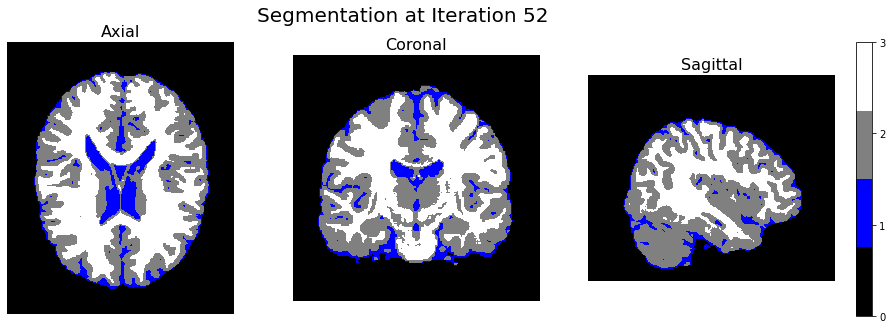

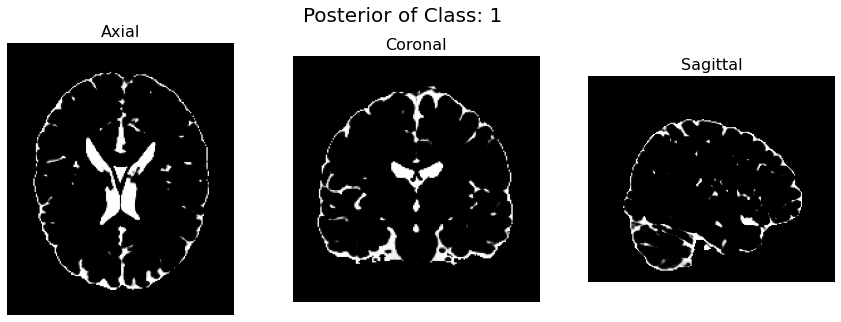

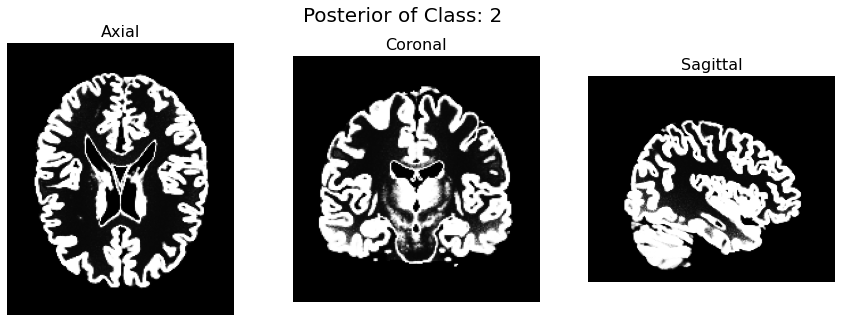

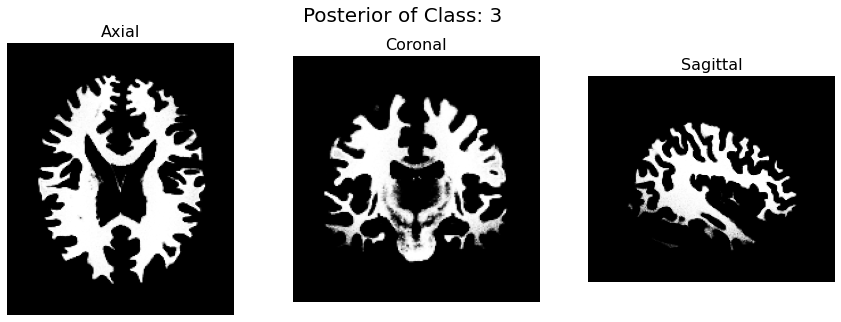

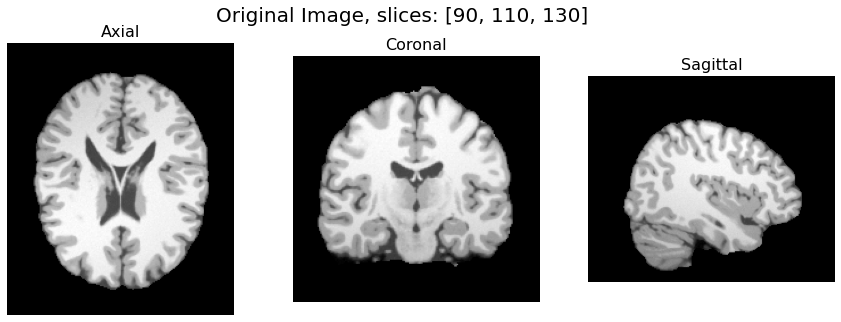

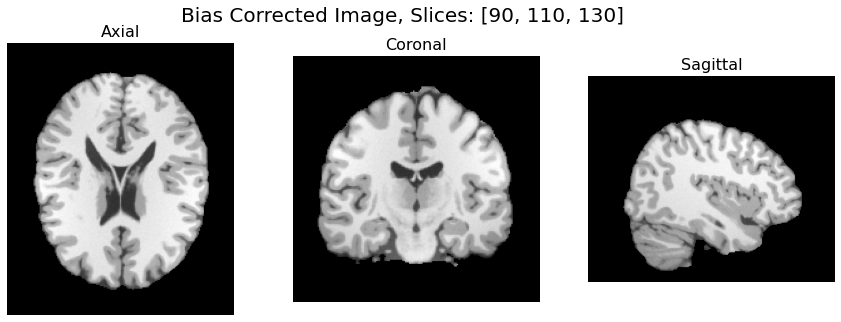

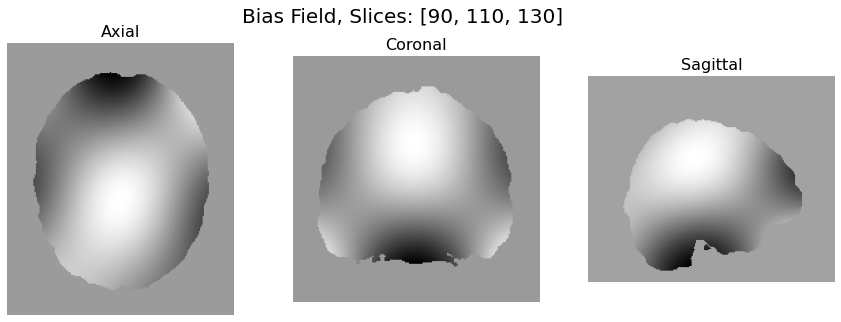

In [33]:
softPlots = True
plotHardPosterior(slices, it)
if softPlots:
    plotSoftPosterior(slices)
plotOriginalImage(brainImage, slices, title='Original Image')
plotBiasCorrectedImage(c, slices)
plotBiasField(c, slices)